In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling

import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
#  Options 
pd.set_option("display.max_rows", 1091)

In [3]:
def generate_model(features,target):
    model = LinearRegression()
    model.fit(features, target)
    training_score = model.score(features,target)
    validation_score = cross_val_score(model,features, target, cv=10, scoring='r2').mean()
    return training_score , validation_score, model

In [4]:
def model_summary(features,target):
    features = sm.add_constant(features)
    model = sm.OLS(target,features)
    fit = model.fit()
    return fit.summary()

In [5]:
def remove_outlier(dataframe, column):
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)
    iqr = q3-q1 
    lower_bound  = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    handled_outliers = dataframe.loc[(dataframe[column] > lower_bound) & (dataframe[column] < upper_bound)]
    return handled_outliers

In [6]:

def diagnostic_plot(x, y_log):
    plt.figure(figsize=(20,5))
    rgr = LinearRegression()
    rgr.fit(x,y_log)
    pred = rgr.predict(x)
    plt.subplot(1, 3, 2)
    res = y_log - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a
    # specified theoretical distribution
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.savefig('resid_bl.png')

In [7]:
pickle_in = open("feature_engineered.pkl","rb")
dataset = pickle.load(pickle_in)

In [9]:
dataset = dataset.sample(frac=1, random_state = 4).reset_index(drop=True)

In [10]:
target = dataset.loc[:, dataset.columns == 'price']
features = dataset.loc[:, dataset.columns != 'price']


In [11]:
features_train, features_test, target_train, target_test = train_test_split(features,target, test_size=0.2, random_state=42, )


In [19]:
#baseline features
bl_features = features_train.loc[:, ['item_package_quantity','gross_wieght', 'net_wieght',  'carat_CT', 'diamond_pcs']]
bl_train_dataset = pd.merge(bl_features, target_train, on= bl_features.index)


In [20]:
bl_train_dataset.drop(columns = ['key_0'], inplace = True)

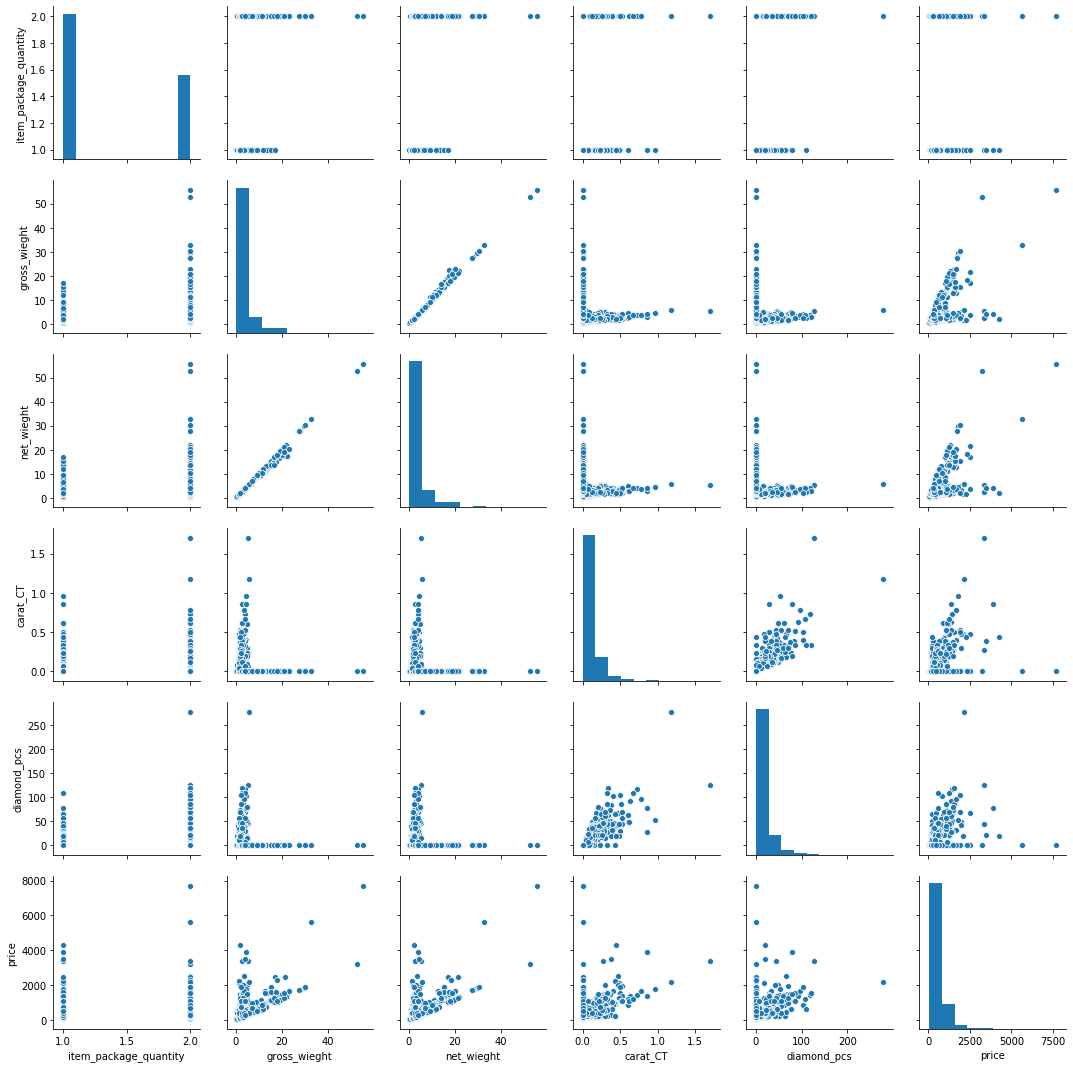

In [21]:
sns.pairplot(bl_train_dataset)

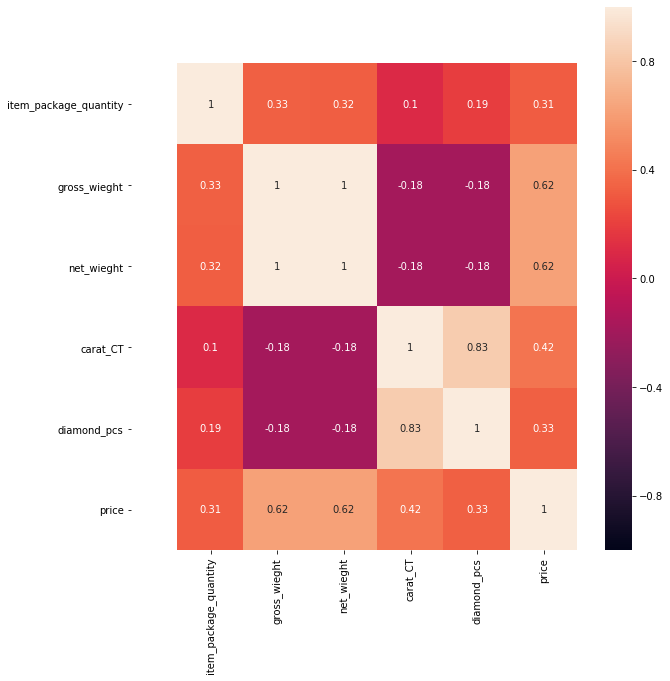

In [22]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(bl_train_dataset.corr(), annot=True, vmin=-1, vmax=1, ax=ax );
plt.xlim(-0.7, 6)
plt.ylim(6,-0.7)
fig.savefig('heatmap_bl.png', dpi=400)

In [23]:
bl_train_dataset.corr()

,item_package_quantity,gross_wieght,net_wieght,carat_CT,diamond_pcs,price
item_package_quantity,1.000000,0.329795,0.321774,0.100687,0.189289,0.314870
gross_wieght,0.329795,1.000000,0.997549,-0.180345,-0.183884,0.617630
net_wieght,0.321774,0.997549,1.000000,-0.180357,-0.184153,0.619201
carat_CT,0.100687,-0.180345,-0.180357,1.000000,0.832387,0.419317
diamond_pcs,0.189289,-0.183884,-0.184153,0.832387,1.000000,0.333930
price,0.314870,0.617630,0.619201,0.419317,0.333930,1.000000


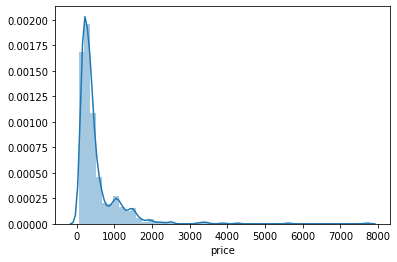

In [17]:
target_dist_bl= sns.distplot(bl_train_dataset['price'])
figure = target_dist_bl.get_figure()    
figure.savefig('target_dist_bl.png', dpi=400)

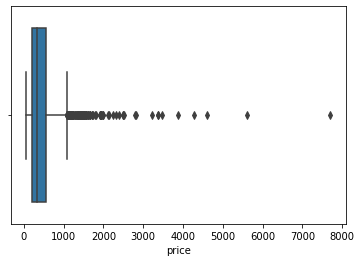

In [18]:
sns.boxplot(dataset['price'])

# Baseline

In [24]:
traning_score1, validation_score1, model = generate_model(bl_features, target_train)


In [25]:
traning_score1

0.6758845221143476

In [26]:
validation_score1

0.6321083633479649

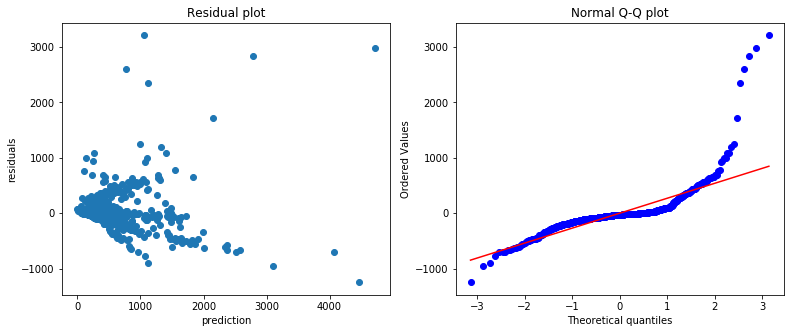

In [27]:
diagnostic_plot(bl_features, target_train['price'] )

In [28]:
model_summary(bl_features, target_train)

/Users/hi/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     342.8
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          2.77e-198
Time:                        09:31:34   Log-Likelihood:                -5983.8
No. Observations:                 828   AIC:                         1.198e+04
Df Residuals:                     822   BIC:                         1.201e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -73.3776     35.877     -2.045      0.041    -143.798      -2.957
item_package_quantity    36.8856     26.774      1.378      0.169     -15.668      89.439
gross_wieght             -2.1544     33.250     -0.065      0.948     -67.419      63.111
net_wieght               87.1278     34.237      2.545      0.011      19.926     154.329
carat_CT               2079.2861    141.815     14.662      0.000    1800.924    2357.648
diamond_pcs               0.5048      0.988      0.511      0.610      -1.434       2.444
==============================================================================
Omnibus:                      773.005   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38391.354
Skew:                           4.107   Prob(JB):                         0.00
Kurtosis:                      35.332   Cond. No.                         301.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Baseline without outliers

In [29]:
wo_outliers = remove_outlier(bl_train_dataset, 'price')

In [30]:
wo_outliers_features = wo_outliers.loc[:, ['item_package_quantity', 'net_wieght', 'carat_CT','diamond_pcs']]
wo_outliers_target = wo_outliers.loc[:, wo_outliers.columns == 'price']

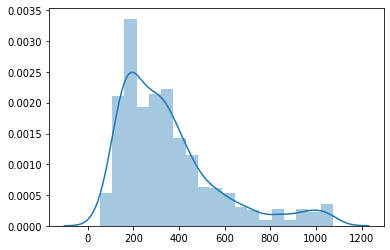

In [31]:
sns.distplot(wo_outliers_target)

In [35]:
traning_score2, validation_score2, model = generate_model(wo_outliers_features, wo_outliers_target)

In [36]:
model_summary(wo_outliers_features, wo_outliers_target)

/Users/hi/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     276.5
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          3.76e-144
Time:                        09:32:05   Log-Likelihood:                -4629.2
No. Observations:                 729   AIC:                             9268.
Df Residuals:                     724   BIC:                             9291.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -20.3058     16.468     -1.233      0.218     -52.637      12.025
item_package_quantity    74.2032     11.726      6.328      0.000      51.181      97.225
net_wieght               56.8762      2.288     24.858      0.000      52.384      61.368
carat_CT                961.9437    104.060      9.244      0.000     757.648    1166.239
diamond_pcs               2.6700      0.649      4.117      0.000       1.397       3.943
==============================================================================
Omnibus:                      286.121   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1433.090
Skew:                           1.724   Prob(JB):                         0.00
Kurtosis:                       8.940   Cond. No.                         358.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

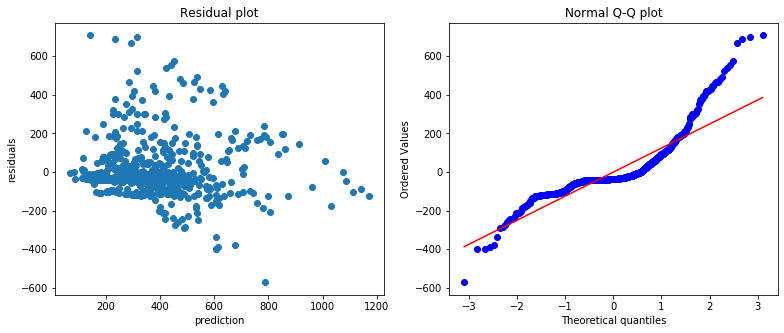

In [37]:
diagnostic_plot(wo_outliers_features, wo_outliers_target['price'] )

# Log transformation on price

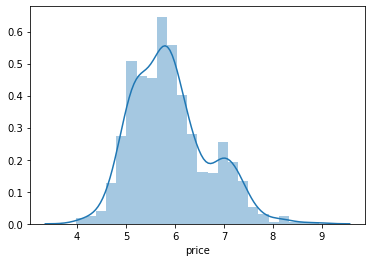

In [38]:
sns.distplot(np.log(target_train['price']))

In [39]:
traning_score3, validation_score3, model = generate_model(bl_features, np.log(target_train))


In [40]:
traning_score3

0.6426664311265542

In [41]:
validation_score3

0.6173945400211196

In [42]:
model_summary(bl_features, np.log(target_train))

/Users/hi/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     295.7
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          6.69e-181
Time:                        09:32:08   Log-Likelihood:                -540.79
No. Observations:                 828   AIC:                             1094.
Df Residuals:                     822   BIC:                             1122.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.9721      0.050     99.229      0.000       4.874       5.070
item_package_quantity     0.2048      0.037      5.476      0.000       0.131       0.278
gross_wieght              0.1734      0.046      3.733      0.000       0.082       0.265
net_wieght               -0.0822      0.048     -1.719      0.086      -0.176       0.012
carat_CT                  2.3677      0.198     11.954      0.000       1.979       2.756
diamond_pcs               0.0044      0.001      3.156      0.002       0.002       0.007
==============================================================================
Omnibus:                       64.828   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              295.223
Skew:                           0.151   Prob(JB):                     7.82e-65
Kurtosis:                       5.910   Cond. No.                         301.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

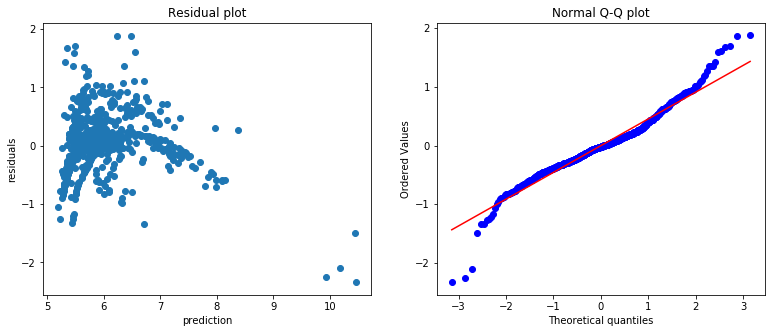

In [43]:
diagnostic_plot(bl_features, np.log(target_train['price']))

# Adding one-hot encoded features

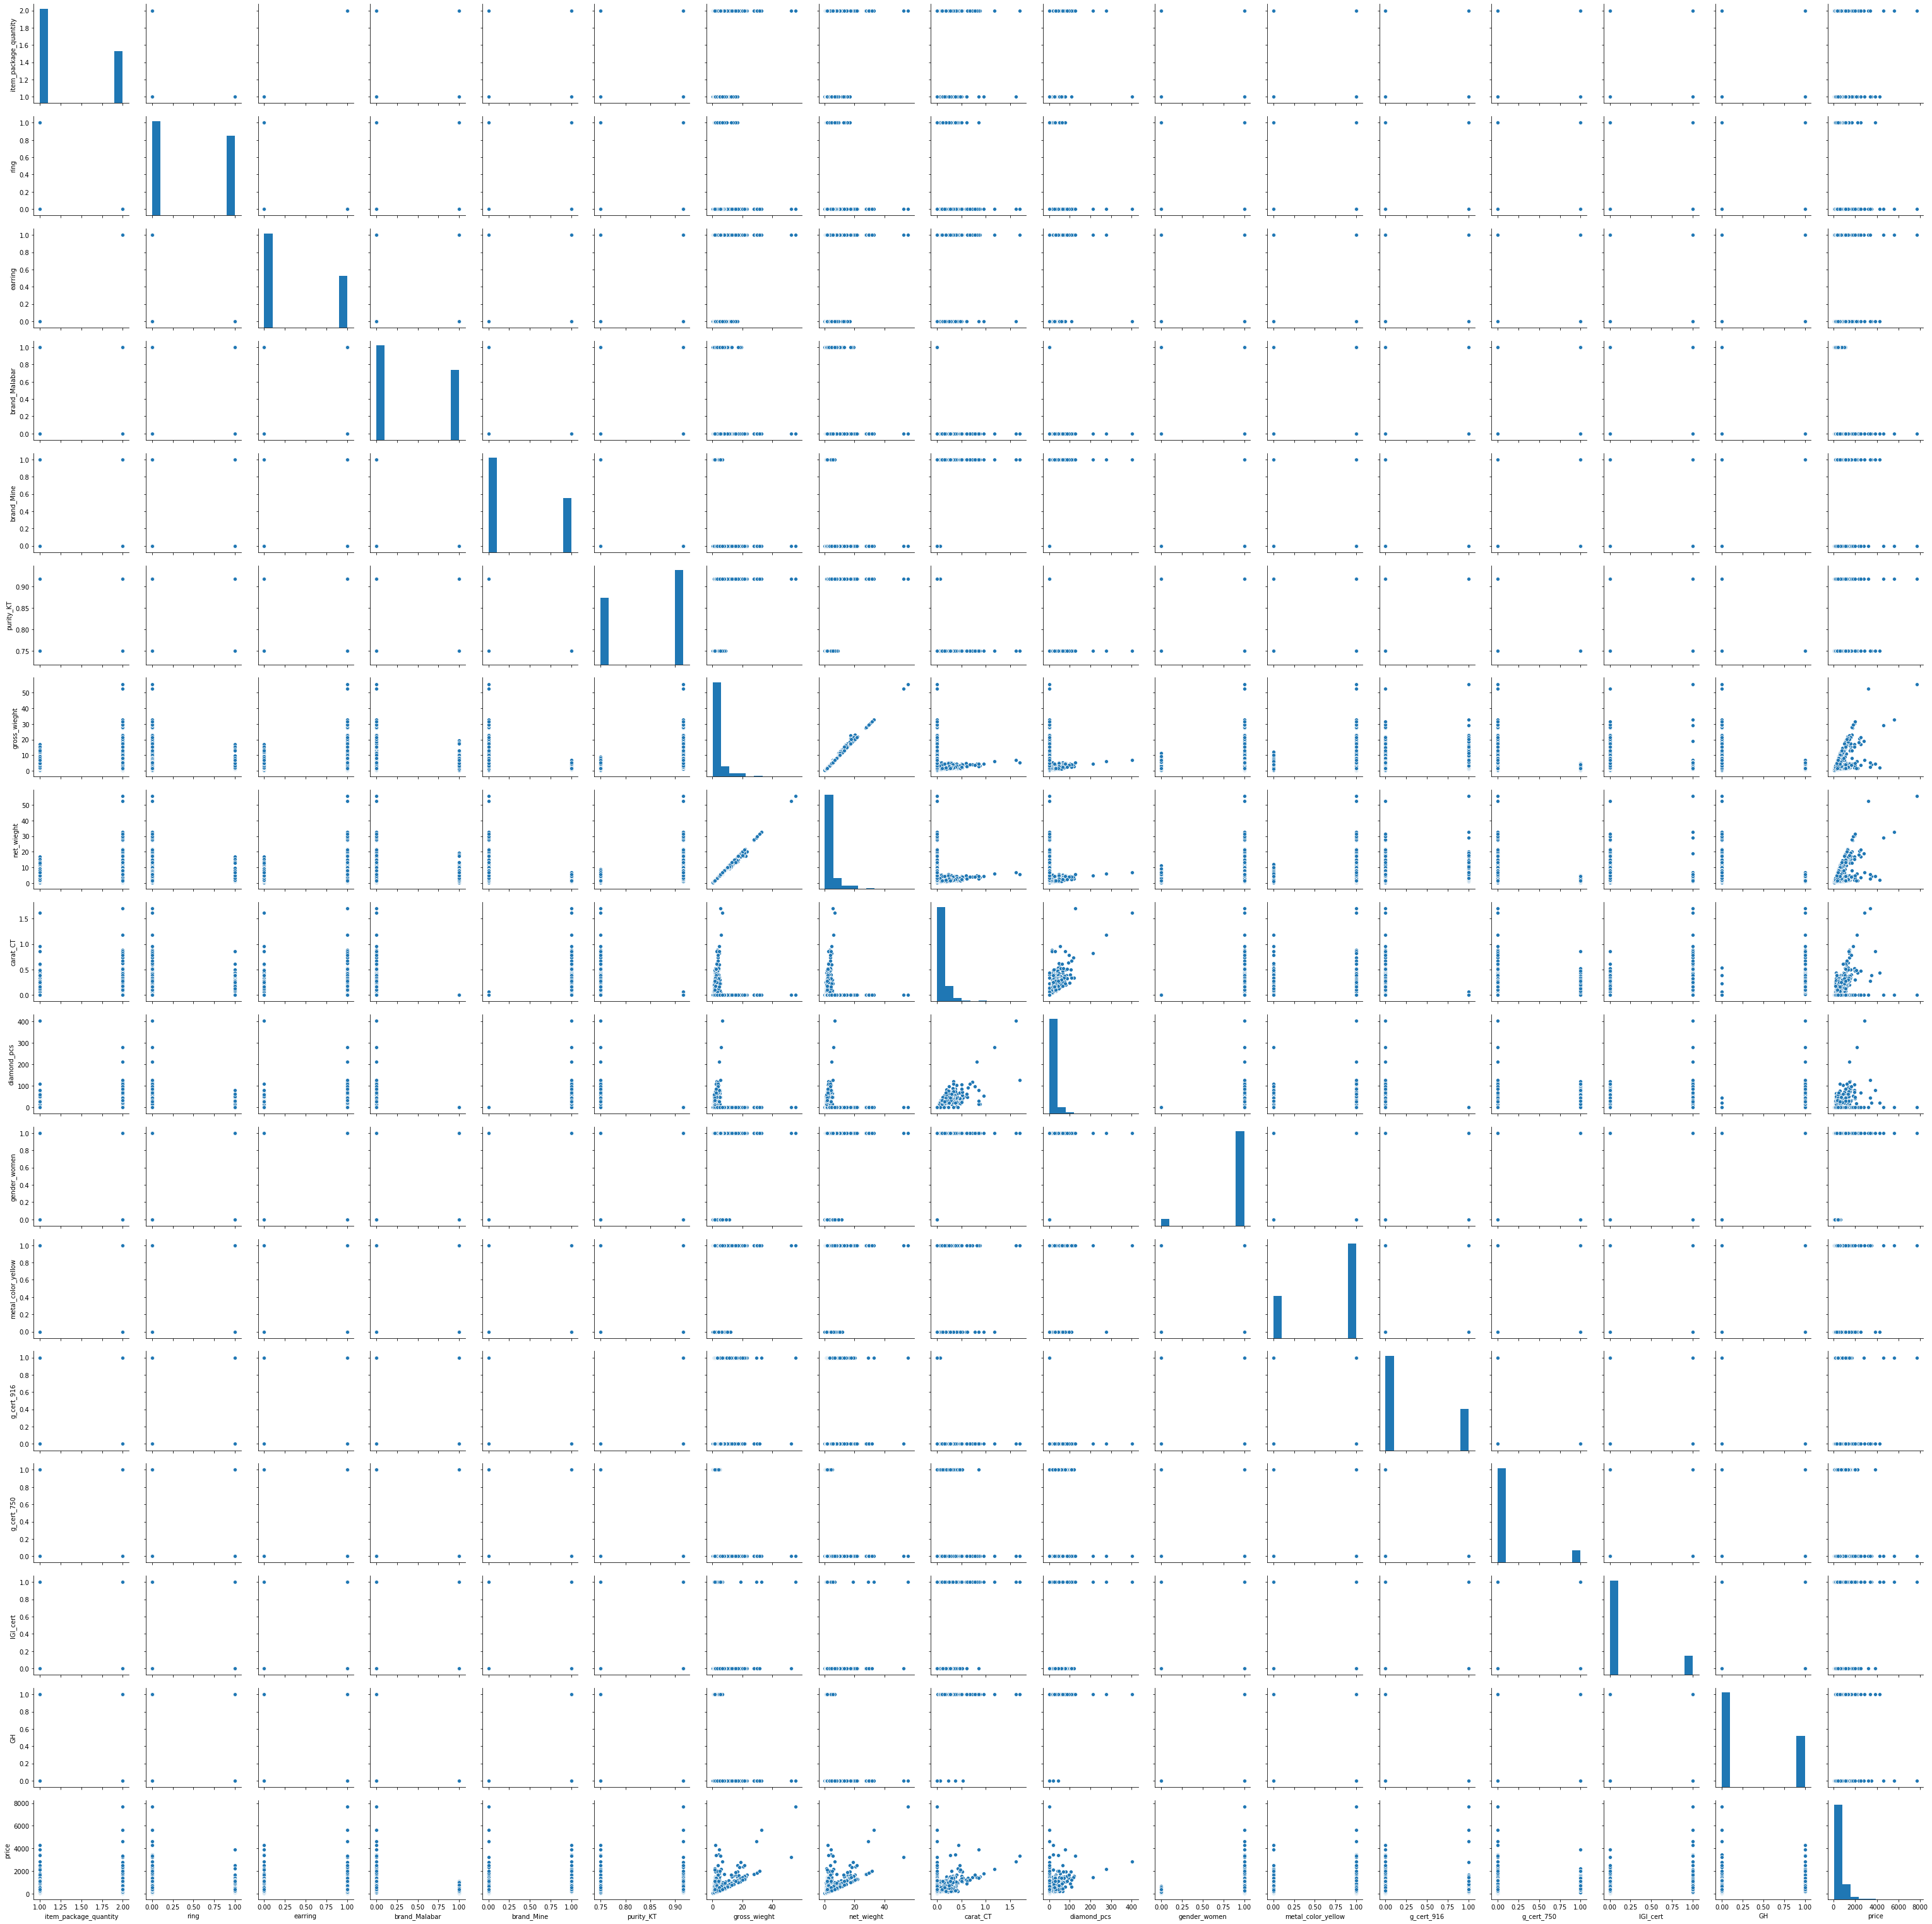

In [44]:
sns.pairplot(dataset)

(17, -0.7)

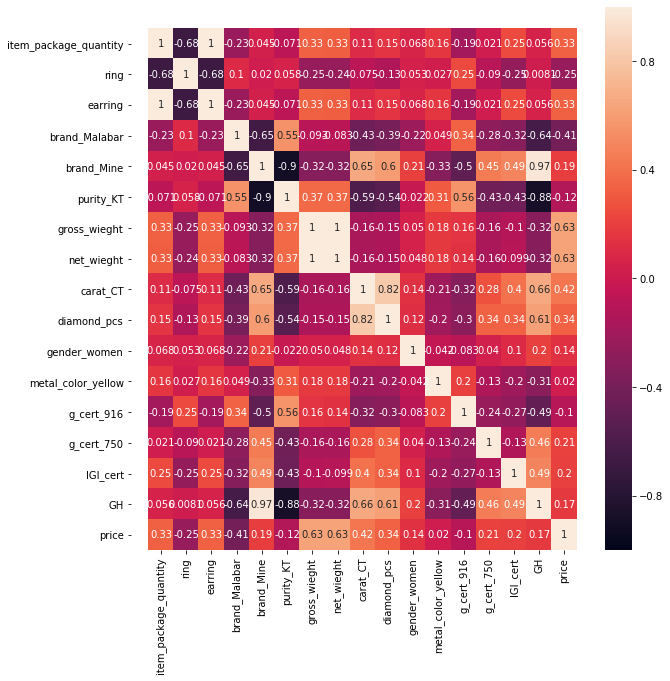

In [45]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(dataset.corr(), annot=True, vmin=-1, vmax=1, ax=ax );
plt.xlim(-0.7, 17)
plt.ylim(17,-0.7)

In [46]:
# features_train, features_test, target_train, target_test

In [48]:
traning_score4, validation_score4, model = generate_model(features_train, target_train)


In [49]:
traning_score4

0.7523382531737675

In [50]:
validation_score4

0.7308991662632067

In [51]:
model_summary(features_train, target_train)

/Users/hi/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     164.4
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          6.53e-234
Time:                        09:34:48   Log-Likelihood:                -5872.4
No. Observations:                 828   AIC:                         1.178e+04
Df Residuals:                     812   BIC:                         1.185e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   192.4317    203.405      0.946      0.344    -206.830     591.693
item_package_quantity    99.8979    100.756      0.991      0.322     -97.875     297.671
ring                     41.5153     32.179      1.290      0.197     -21.648     104.679
earring                 -92.5338    105.239     -0.879      0.380    -299.105     114.038
brand_Malabar          -139.2010     31.324     -4.444      0.000    -200.687     -77.715
brand_Mine              381.0797    111.761      3.410      0.001     161.704     600.455
purity_KT              -423.0253    353.637     -1.196      0.232   -1117.176     271.125
gross_wieght            -37.1967     31.606     -1.177      0.240     -99.235      24.842
net_wieght              123.2706     32.403      3.804      0.000      59.667     186.874
carat_CT               2044.8084    130.909     15.620      0.000    1787.848    2301.769
diamond_pcs              -1.7011      0.930     -1.830      0.068      -3.526       0.123
gender_women             63.0747     45.526      1.385      0.166     -26.288     152.437
metal_color_yellow       22.4284     25.061      0.895      0.371     -26.764      71.621
g_cert_916               49.8539     29.642      1.682      0.093      -8.331     108.038
g_cert_750              546.4279     42.523     12.850      0.000     462.961     629.895
IGI_cert                286.6585     38.668      7.413      0.000     210.758     362.559
GH                     -655.5128     92.395     -7.095      0.000    -836.873    -474.152
==============================================================================
Omnibus:                      822.002   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59392.882
Skew:                           4.391   Prob(JB):                         0.00
Kurtosis:                      43.551   Cond. No.                     1.87e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.44e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

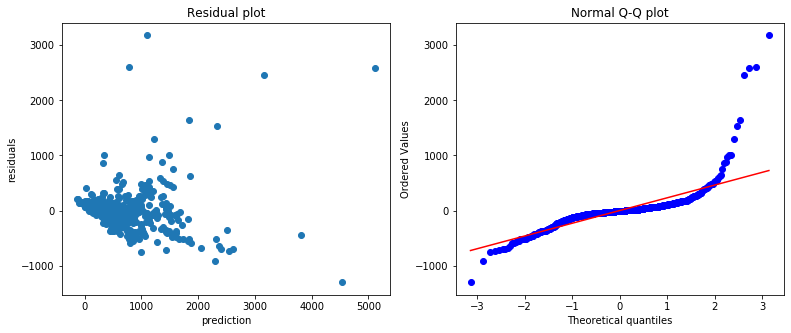

In [52]:
diagnostic_plot(features_train, target_train['price'])

I'll try first with all features then exclude the ones with low correlation with the price such as:
* __Metal_color_yellow__
* __g_cert_750__
* __purity_KT__
* __GH__
* __Brand_mine__

I'll also consider removing the __gross weight__ since it is highly correlated with the net weight.

# Excluding some features 

In [53]:
f = features_train.loc[:,[  'brand_Malabar', 'purity_KT', 'net_wieght', 'carat_CT',
       'diamond_pcs', 'g_cert_750', 'IGI_cert'] ]




In [56]:
traning_score5, validation_score5, model = generate_model(f, target_train)

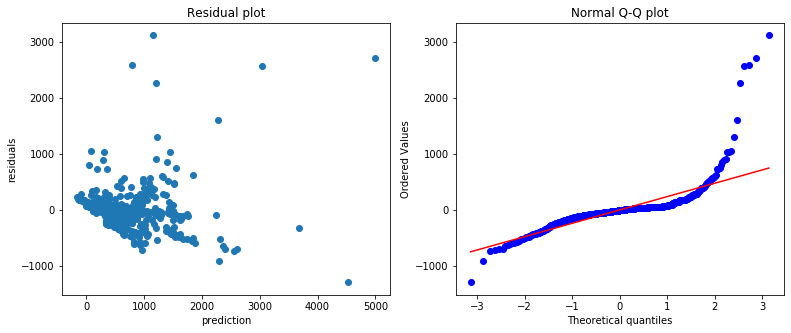

In [57]:

diagnostic_plot(f, target_train['price'] )

In [58]:
model_summary(f, target_train)

/Users/hi/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     320.5
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          9.38e-230
Time:                        09:35:07   Log-Likelihood:                -5904.5
No. Observations:                 828   AIC:                         1.183e+04
Df Residuals:                     820   BIC:                         1.186e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -479.6854    182.284     -2.632      0.009    -837.483    -121.887
brand_Malabar  -104.2656     27.981     -3.726      0.000    -159.188     -49.343
purity_KT       528.1418    217.098      2.433      0.015     102.008     954.275
net_wieght       85.7632      2.499     34.321      0.000      80.858      90.668
carat_CT       2021.0129    133.453     15.144      0.000    1759.064    2282.962
diamond_pcs      -2.8539      0.926     -3.081      0.002      -4.672      -1.036
g_cert_750      480.7487     41.652     11.542      0.000     398.991     562.506
IGI_cert        224.6846     35.175      6.388      0.000     155.641     293.728
==============================================================================
Omnibus:                      828.353   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54336.746
Skew:                           4.494   Prob(JB):                         0.00
Kurtosis:                      41.655   Cond. No.                         664.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I'll try removing outliers 

# The one!!

# One-hot encoding + without outliers + log transformation

In [59]:


merged_eng_train = pd.merge(features_train, target_train, on= features_train.index)
merged_eng_test = pd.merge(features_test, target_test, on= features_test.index)



In [60]:
engineered_train_wo_outliers= remove_outlier(merged_eng_train, 'price')
engineered_test_wo_outliers= remove_outlier(merged_eng_test, 'price')

In [61]:
#split target column from features column 
target_eng_wo_outliers = engineered_train_wo_outliers.loc[:, engineered_train_wo_outliers.columns == 'price']
features_eng_wo_outliers = engineered_train_wo_outliers.loc[:,['brand_Malabar', 'purity_KT', 'net_wieght', 'carat_CT', 'g_cert_750', 'IGI_cert']]


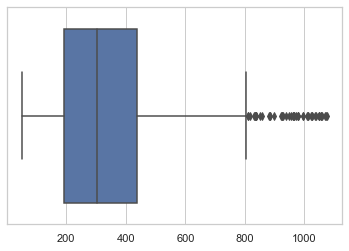

In [62]:
sns.set(style="whitegrid")
sns.boxplot(x=target_eng_wo_outliers)

price    5.697852
dtype: float64

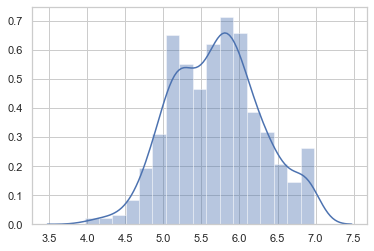

In [63]:
sns.distplot(np.log(target_eng_wo_outliers))
np.log(target_eng_wo_outliers).mean()

In [64]:
traning_score6, validation_score6, model = generate_model(features_eng_wo_outliers, np.log(target_eng_wo_outliers))


In [65]:
traning_score6

0.7775840543534779

In [66]:
validation_score6

0.7677309105483371

In [67]:
target_t= np.log(target_eng_wo_outliers)

In [68]:
engineered_test_wo_outliers_features = engineered_test_wo_outliers.loc[:, ['brand_Malabar', 'purity_KT', 'net_wieght', 'carat_CT', 'g_cert_750', 'IGI_cert']]
engineered_test_wo_outliers_target = engineered_test_wo_outliers.loc[:,engineered_test_wo_outliers.columns == 'price' ]


In [69]:
predictions = model.predict(engineered_test_wo_outliers_features)

In [70]:
model.score(engineered_test_wo_outliers_features, np.log(engineered_test_wo_outliers_target))

0.7417069500620168

In [71]:
model_summary(features_eng_wo_outliers, np.log(target_eng_wo_outliers))

/Users/hi/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     420.7
Date:                Thu, 19 Sep 2019   Prob (F-statistic):          8.45e-232
Time:                        09:35:16   Log-Likelihood:                -94.419
No. Observations:                 729   AIC:                             202.8
Df Residuals:                     722   BIC:                             235.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.6002      0.191     24.026      0.000       4.224       4.976
brand_Malabar    -0.4303      0.027    -16.051      0.000      -0.483      -0.378
purity_KT         0.5929      0.226      2.624      0.009       0.149       1.036
net_wieght        0.1654      0.005     34.507      0.000       0.156       0.175
carat_CT          1.9961      0.162     12.357      0.000       1.679       2.313
g_cert_750        0.6362      0.042     15.192      0.000       0.554       0.718
IGI_cert          0.3048      0.033      9.152      0.000       0.239       0.370
==============================================================================
Omnibus:                       83.688   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              338.744
Skew:                          -0.455   Prob(JB):                     2.77e-74
Kurtosis:                       6.213   Cond. No.                         135.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

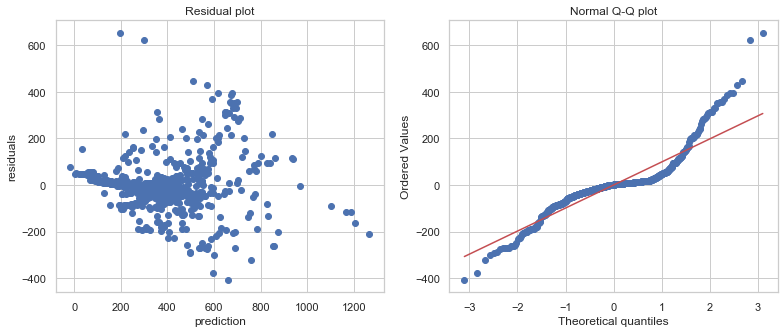

In [72]:
diagnostic_plot(features_eng_wo_outliers, target_eng_wo_outliers['price'] )

In [73]:
merged_eng_dataset = pd.merge(features_eng_wo_outliers, target_eng_wo_outliers, on= features_eng_wo_outliers.index)


In [74]:
merged_eng_dataset.drop(columns = ['key_0'], inplace = True)

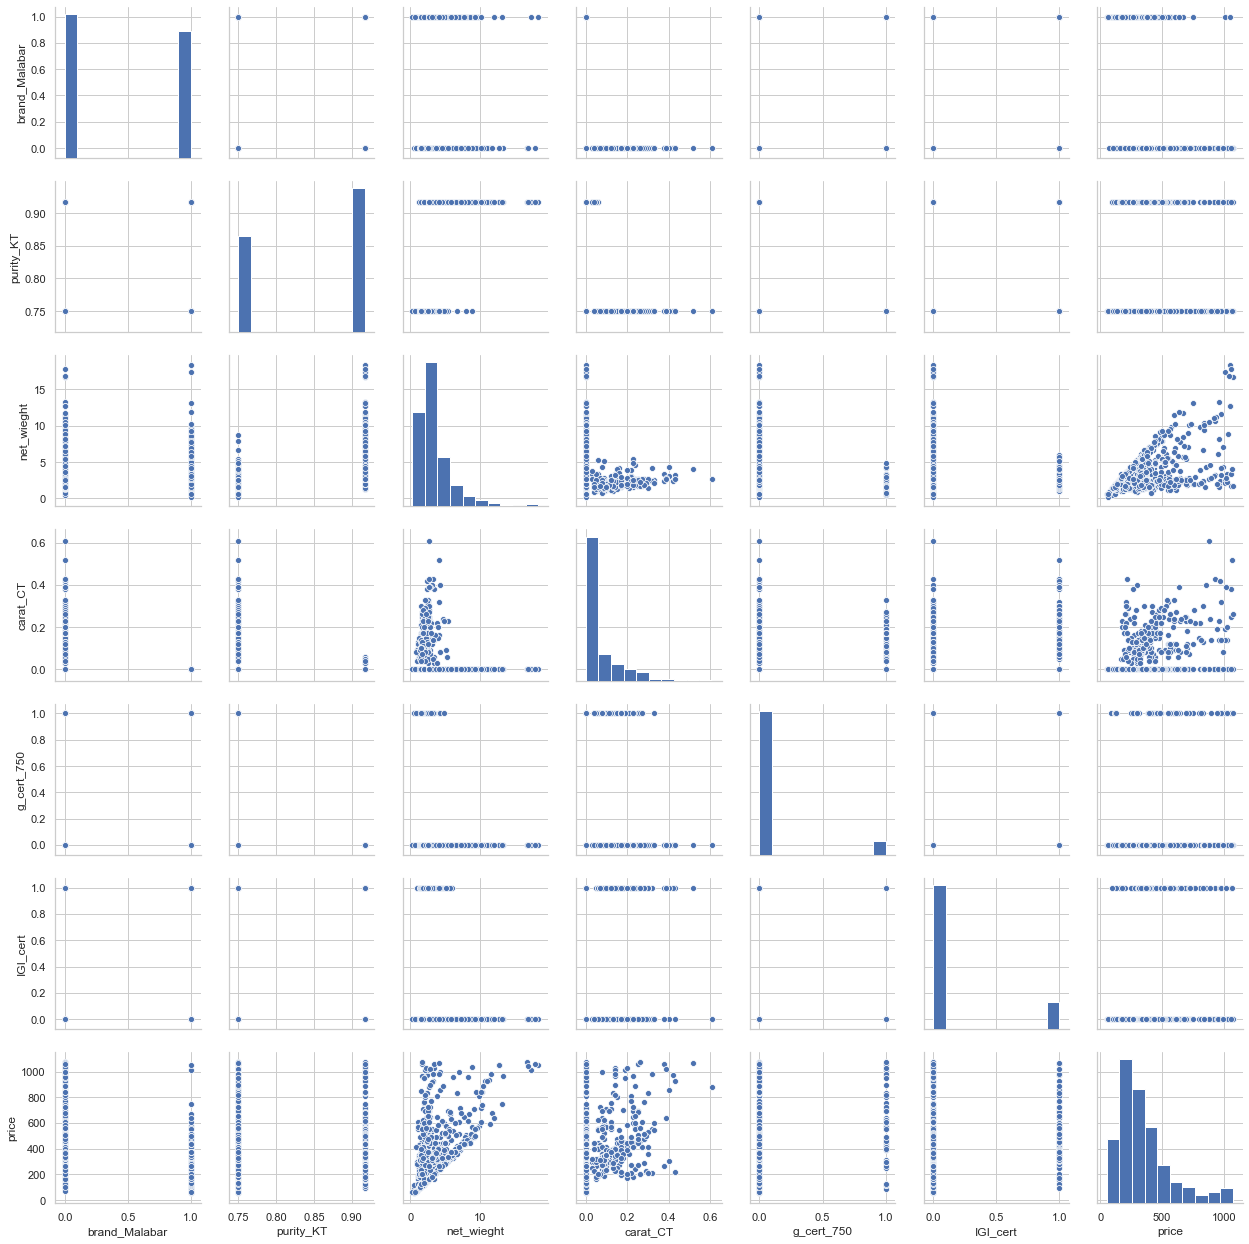

In [75]:
sns.pairplot(merged_eng_dataset)